In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xvzf lfw.tgz

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Ai

In [ ]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle

In [ ]:
face_images = glob.glob('lfw/**/*.jpg') #returns path of images
print(len(face_images)) #contains 13243 images

13233


In [ ]:
from tqdm import tqdm
from multiprocessing import Pool

progress = tqdm(total= len(face_images), position=0)
def read(path):
  img = image.load_img(path, target_size=(80,80,3))
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img

p = Pool(20)
img_array = p.map(read, face_images)

  6%|▌         | 818/13233 [00:47<02:30, 82.56it/s]

In [ ]:
with open('img_array.pickle','wb') as f:
  pickle.dump(img_array, f)
  print(len(img_array))

13233


In [ ]:
all_images = np.array(img_array)
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [ ]:
#now we will make input images by lowering resolution without changing the size
def pixalate_image(image, scale_percent = 50):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)
  
  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)
  
  low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA)
  return low_res_image

In [ ]:
train_x_px = []
for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)
train_x_px = np.array(train_x_px)   #Distorted images# get low resolution images for the validation set
val_x_px = []
for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)
val_x_px = np.array(val_x_px)     #Distorted images

In [ ]:
Input_img = Input(shape=(80, 80, 3))

# encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same',
            kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same',
            kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same',
            kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same',
            kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=regularizers.l1(10e-10))(x6)
# encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same',
            kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same',
            kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])
x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same',
             kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same',
             kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])  # x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same', activation='relu',
                 kernel_regularizer=regularizers.l1(10e-10))(x14)
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
autoencoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 40, 64)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [ ]:
early_stopper = EarlyStopping(
    monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint(
    'superResolution_checkpoint3.h5', save_best_only=True)

history = autoencoder.fit(train_x_px, train_x,
                          epochs=2,
                          validation_data=(val_x_px, val_x),
                          callbacks=[early_stopper, model_checkpoint])

Epoch 1/2
331/331 [==============================] - 3426s 10s/step - loss: 0.0065 - accuracy: 0.8505 - val_loss: 0.0019 - val_accuracy: 0.9104
Epoch 2/2
331/331 [==============================] - 3368s 10s/step - loss: 0.0018 - accuracy: 0.9088 - val_loss: 0.0018 - val_accuracy: 0.8926


In [33]:
custom_img = np.array([
  cv2.imread("green-maple-leaf.jpg"),
  cv2.imread("home-office.jpg"),
  cv2.imread("martin-luther-king.jpg"),
  cv2.imread("mount-rushmore.jpg"),
  cv2.imread("salisbury-cathedral.jpg")])

custom_px = np.copy(val_x_px)
for i in range(len(custom_img)):
  custom_px[i] = pixalate_image(cv2.cvtColor(custom_img[i], cv2.COLOR_BGR2RGB)/255)

(2647, 80, 80, 3)


In [34]:
results = autoencoder.evaluate(custom_px, val_x)
print('val_loss, val_accuracy', results)

83/83 [==============================] - 206s 2s/step - loss: 0.0020 - accuracy: 0.8915
val_loss, val_accuracy [0.0020374394953250885, 0.8914734125137329]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


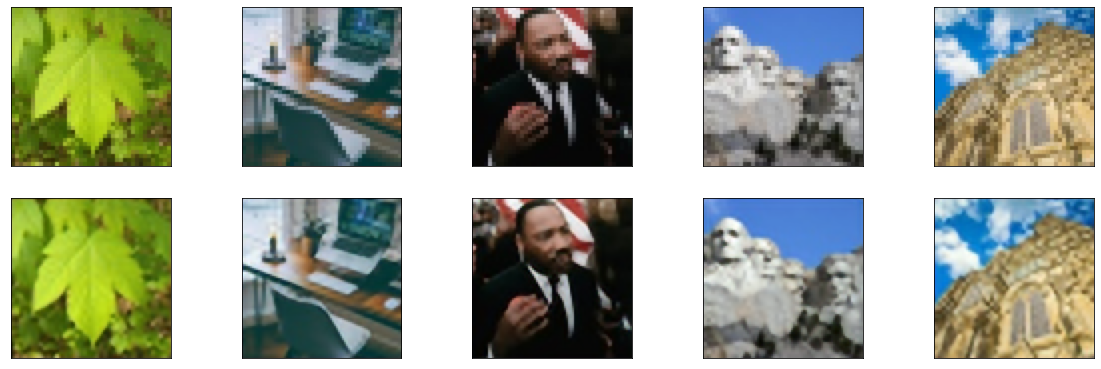

In [36]:
n = 5
predictions = autoencoder.predict(custom_px)
plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(custom_px[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(predictions[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [46]:
def normalize(x):
  return x/np.max(x)

plt.imsave("cnn-autoencoder_processed/green-maple-leaf.jpg", normalize(predictions[0]))
plt.imsave("cnn-autoencoder_processed/home-office.jpg", normalize(predictions[1]))
plt.imsave("cnn-autoencoder_processed/martin-luther-king.jpg", normalize(predictions[2]))
plt.imsave("cnn-autoencoder_processed/mount-rushmore.jpg", normalize(predictions[3]))
plt.imsave("cnn-autoencoder_processed/salisbury-cathedral.jpg", normalize(predictions[4]))